In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
def extract_experiments(experiment_states):
    for exp_state in experiment_states:
        if exp_state.rev == 'workspace':
            continue
            
        experiments = exp_state.experiments or []

        for experiment in experiments:
            revs = experiment.revs or []
            for rev in revs:
                params = next(iter(rev.data.params.values()), {}).get("data")
                metrics = next(iter(rev.data.metrics.values()), {}).get("data")
                yield {
                    'commit': exp_state.rev,
                    'id': rev.rev,
                    'name': rev.name,
                    'params': params,
                    'metrics': metrics,
                }

In [3]:
from dvc.repo import Repo

# Initialize a DVC Repo object
repo = Repo()

# Get the experiments
experiments = list(extract_experiments(repo.experiments.show(num=100)))

In [20]:
df = (
    pd.json_normalize(experiments)
    .sort_values(["params.model", "params.prompt", "params.temperature", "params.run"])
    .drop(columns=["commit", "id", "name"])
)
df

,params.prompt,params.model,params.temperature,params.run,metrics.exact_match,metrics.f1,metrics.fuzzy_match
41,cot-fs,llama-3-70b-tgi,0.0,1,0.50,0.545405,0.53
40,cot-fs,llama-3-70b-tgi,0.0,2,0.50,0.545405,0.53
39,cot-fs,llama-3-70b-tgi,0.0,3,0.51,0.555405,0.54
38,cot-fs,llama-3-70b-tgi,0.1,1,0.52,0.572072,0.56
37,cot-fs,llama-3-70b-tgi,0.1,2,0.50,0.552294,0.53
...,...,...,...,...,...,...,...
66,standard,llama-3-70b-tgi,1.5,2,0.56,0.655746,0.61
67,standard,llama-3-70b-tgi,1.5,3,0.52,0.634006,0.58
65,standard,llama-3-70b-tgi,2.0,1,0.25,0.372516,0.31
64,standard,llama-3-70b-tgi,2.0,2,0.30,0.392757,0.34


In [21]:
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [29]:
df.drop(columns=['params.model']).groupby(["params.prompt", "params.temperature"]).aggregate(['mean', 'max']).loc[:, metric_cols]

metrics.exact_match       metrics.f1  \
                                                mean   max       mean   
params.prompt params.temperature                                        
cot-fs        0.0                           0.503333  0.51   0.548739   
              0.1                           0.510000  0.52   0.562146   
              0.5                           0.523333  0.55   0.582568   
              0.7                           0.496667  0.50   0.556218   
              1.0                           0.520000  0.54   0.572405   
              1.5                           0.490000  0.50   0.554659   
              2.0                           0.216667  0.23   0.281394   
cot-zs        0.0                           0.476667  0.48   0.566850   
              0.1                           0.500000  0.52   0.585980   
              0.5                           0.513333  0.54   0.593794   
              0.7                           0.486667  0.50   0.571275   
              1.0                           0.490000  0.50   0.579325   
              1.5                           0.460000  0.47   0.531791   
              2.0                           0.116667  0.18   0.169882   
cte           0.0                           0.620000  0.62   0.697026   
              0.1                           0.610000  0.62   0.695664   
              0.5                           0.626667  0.64   0.705255   
              0.7                           0.646667  0.65   0.724728   
              1.0                           0.623333  0.64   0.699528   
              1.5                           0.603333  0.62   0.695496   
              2.0                           0.363333  0.39   0.423753   
standard      0.0                           0.560000  0.56   0.663301   
              0.1                           0.530000  0.53   0.653238   
              0.5                           0.570000  0.58   0.667598   
              0.7                           0.560000  0.57   0.663480   
              1.0                           0.516667  0.53   0.640081   
              1.5                           0.540000  0.56   0.645551   
              2.0                           0.276667  0.30   0.382217   

                                           metrics.fuzzy_match        
                                       max                mean   max  
params.prompt params.temperature                                      
cot-fs        0.0                 0.555405            0.533333  0.54  
              0.1                 0.572072            0.546667  0.56  
              0.5                 0.602072            0.563333  0.59  
              0.7                 0.564017            0.530000  0.54  
              1.0                 0.588739            0.550000  0.57  
              1.5                 0.566042            0.526667  0.54  
              2.0                 0.286862            0.236667  0.26  
cot-zs        0.0                 0.575183            0.530000  0.53  
              0.1                 0.598517            0.556667  0.57  
              0.5                 0.611977            0.566667  0.58  
              0.7                 0.586017            0.523333  0.53  
              1.0                 0.593726            0.526667  0.53  
              1.5                 0.535755            0.493333  0.51  
              2.0                 0.231684            0.140000  0.21  
cte           0.0                 0.697246            0.670000  0.67  
              0.1                 0.704330            0.666667  0.68  
              0.5                 0.713250            0.686667  0.70  
              0.7                 0.735577            0.700000  0.72  
              1.0                 0.709061            0.676667  0.69  
              1.5                 0.699423            0.650000  0.67  
              2.0                 0.455174            0.396667  0.42  
standard      0.0                 0.663301            0.630000  0

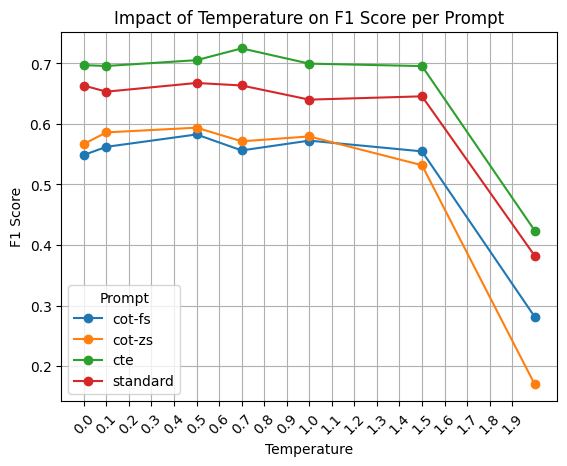

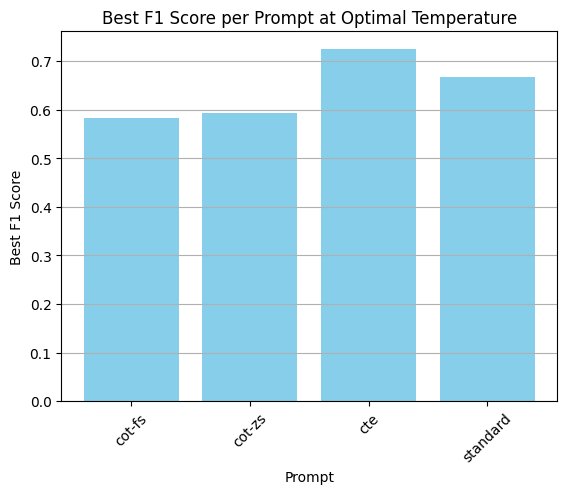

In [15]:
# Average metrics over repeated runs (params.run)
df_avg = df.groupby(['params.prompt', 'params.temperature'])[['metrics.exact_match', 'metrics.f1', 'metrics.fuzzy_match']].mean().reset_index()

# Plotting the impact of temperature per prompt
prompts = df_avg['params.prompt'].unique()

for prompt in prompts:
    subset = df_avg[df_avg['params.prompt'] == prompt]
    plt.plot(subset['params.temperature'], subset['metrics.f1'], marker='o', label=prompt)

plt.xlabel('Temperature')
plt.ylabel('F1 Score')
plt.title('Impact of Temperature on F1 Score per Prompt')
plt.legend(title='Prompt')
plt.xticks(ticks=list(np.arange(0, 2, 0.1)), rotation=45)  # Adding xticks for temperature values in range(0, 2, 0.1)
plt.grid(True)
plt.show()

# To compare the prompts at the best temperature
# Assuming "best temperature" is defined as the one with the highest average F1 score
best_temperatures = df_avg.loc[df_avg.groupby('params.prompt')['metrics.f1'].idxmax()]

# Plotting the best F1 scores per prompt
plt.bar(best_temperatures['params.prompt'], best_temperatures['metrics.f1'], color='skyblue')
plt.xlabel('Prompt')
plt.ylabel('Best F1 Score')
plt.title('Best F1 Score per Prompt at Optimal Temperature')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()